In [72]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata
import math
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Ensure NLTK data is downloaded
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    stop_words = list(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    print("NLTK data downloaded successfully.")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    print("Proceeding without lemmatization as a fallback.")
    stop_words = []
    lemmatizer = None

# Configuration
DATA_FILE = '/content/FINAL_DATA.csv'
MODEL_FILES = {
    'bow_vectorizer': 'bow_vectorizer.pkl',
    'encoder': 'label_encoder.pkl',
    'model': 'trained_model.pkl'
}

TRAINING_PARAMS = {
    'bow_ngram_range': (1, 1),      # Unigrams only
    'max_features': 15000,          # For large dataset
    'test_size': 0.15,
    'val_size': 0.15,
    'learning_rate': 0.1,
    'decay_rate': 0.005,
    'max_iter': 20000,
    'lambda_reg': 0.01,
    'patience': 5,
    'delta': 0.001,
    'smote_random_state': 42,
    'confidence_threshold': 0.6
}

# Exclusion list and symbols
exclusion_list = ['a', 'an', 'the', 'is', 'are', 'was', 'were', 'be', 'by', 'for', 'in', 'of', 'on', 'to', 'with']
symbols_to_remove = r'[,\.;:!\?\(\)\[\]\{\}\$\=\\\+/\*\^_\|\&#\%\@~`-]'

# Map for scientific characters and LaTeX
LATEX_MAP = {
    r'\\frac\{([^}]+)\}\{([^}]+)\}': r'fraction \1 \2',
    r'\\sum': 'summation',
    r'\\int': 'integral',
    r'\\sqrt': 'square_root',
    r'\\alpha': 'alpha',
    r'\\beta': 'beta',
    r'\\gamma': 'gamma',
    r'\\delta': 'delta',
    r'\\epsilon': 'epsilon',
    r'\\sigma': 'sigma',
    r'\\pi': 'pi',
    r'\\infty': 'infinity',
    r'\\pm': 'plus_minus',
    r'\\rightarrow': 'arrow_right',
    r'\\leq': 'less_equal',
    r'\\geq': 'greater_equal'
}

UNICODE_MAP = {
    'α': 'alpha',
    'β': 'beta',
    'γ': 'gamma',
    'δ': 'delta',
    'ε': 'epsilon',
    'σ': 'sigma',
    'π': 'pi',
    '∑': 'summation',
    '∫': 'integral',
    '∞': 'infinity',
    '±': 'plus_minus',
    '→': 'arrow_right',
    '≤': 'less_equal',
    '≥': 'greater_equal'
}

NLTK data downloaded successfully.


In [ ]:
# Optimized preprocessing function
def preprocess_input(text):
    if not isinstance(text, str):
        return ''

    # Normalize Unicode characters
    text = unicodedata.normalize('NFKD', text)
    for unicode_char, replacement in UNICODE_MAP.items():
        text = text.replace(unicode_char, replacement)

    # Parse LaTeX
    for pattern, replacement in LATEX_MAP.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Remove symbols and lowercase
    text = re.sub(symbols_to_remove, ' ', text.lower())

    # Tokenize and lemmatize
    try:
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(t) for t in tokens
                  if t not in stop_words and t not in exclusion_list and t.isalpha()]
    except Exception:
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(t) for t in tokens
                  if t not in stop_words and t not in exclusion_list and t.isalpha()] if lemmatizer else tokens

    return ' '.join(tokens)

In [ ]:
print("\n=== Section 2: Data Loading and Preprocessing ===")
data = pd.read_csv(DATA_FILE)
print("Loading data complete.")

# Preprocess sequentially
print("Preprocessing texts...")
data['cleaned'] = [preprocess_input(text) for text in tqdm(data['sentence'], desc="Preprocessing")]
data = data[data['cleaned'].str.strip().astype(bool)]

print(f"Dataset size: {len(data)}")
print("\nClass distribution:")
print(data['label'].value_counts())

X_temp, X_test, y_temp, y_test = train_test_split(
    data['cleaned'], data['label'],
    test_size=TRAINING_PARAMS['test_size'],
    stratify=data['label'],
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=TRAINING_PARAMS['val_size']/(1-TRAINING_PARAMS['test_size']),
    stratify=y_temp,
    random_state=42
)

print(f"\nTrain set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


=== Section 2: Data Loading and Preprocessing ===
Loading data complete.
Preprocessing texts...


Streaming output truncated to the last 5000 lines.

Preprocessing:  35%|███▌      | 134250/382880 [01:21<02:13, 1857.00it/s]


Preprocessing:  35%|███▌      | 134436/382880 [01:21<02:20, 1768.40it/s]


Preprocessing:  35%|███▌      | 134633/382880 [01:21<02:16, 1824.86it/s]


Preprocessing:  35%|███▌      | 134817/382880 [01:21<02:16, 1823.27it/s]


Preprocessing:  35%|███▌      | 135005/382880 [01:21<02:14, 1838.65it/s]


Preprocessing:  35%|███▌      | 135190/382880 [01:21<02:14, 1840.26it/s]


Preprocessing:  35%|███▌      | 135381/382880 [01:21<02:13, 1858.60it/s]


Preprocessing:  35%|███▌      | 135568/382880 [01:21<02:13, 1849.29it/s]


Preprocessing:  35%|███▌      | 135762/382880 [01:21<02:11, 1874.72it/s]


Preprocessing:  36%|███▌      | 135964/382880 [01:21<02:08, 1916.25it/s]


Preprocessing:  36%|███▌      | 136161/382880 [01:22<02:07, 1930.61it/s]


Preprocessing:  36%|███▌      | 136355/382880 [01:22<02:15, 1822.26it/s]


Preprocessing:  36%|███▌      | 136546/382880 [0

Dataset size: 382748

Class distribution:
label
Computer Science     132081
Math                 128245
Science & Physics    122422
Name: count, dtype: int64

Train set size: 267922
Validation set size: 57413
Test set size: 57413


In [48]:
print("\n=== Section 3: Vectorization ===")

class AdvancedVectorizer:
    def __init__(self, ngram_range=(1,1), max_features=None, stop_words=None):
        self.vectorizer = TfidfVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            stop_words=stop_words,
            lowercase=False
        )
        self.feature_names = []

    def fit(self, texts):
        print("Preprocessing texts for fit...")
        processed_texts = [preprocess_input(text) for text in tqdm(texts, desc="Preprocessing")]
        self.vectorizer.fit(processed_texts)
        self.feature_names = self.vectorizer.get_feature_names_out().tolist()
        return self

    def transform(self, texts):
        print("Preprocessing texts for transform...")
        processed_texts = [preprocess_input(text) for text in tqdm(texts, desc="Preprocessing")]
        return self.vectorizer.transform(processed_texts)

bow_vectorizer = AdvancedVectorizer(
    ngram_range=TRAINING_PARAMS['bow_ngram_range'],
    max_features=TRAINING_PARAMS['max_features'],
    stop_words=stop_words
).fit(X_train)

print("Transforming training data...")
X_train_bow = bow_vectorizer.transform(X_train)

print("Transforming validation data...")
X_val_bow = bow_vectorizer.transform(X_val)

print("Transforming test data...")
X_test_bow = bow_vectorizer.transform(X_test)

print(f"BoW features: {len(bow_vectorizer.feature_names)}")


=== Section 3: Vectorization ===
Preprocessing texts for fit...





Preprocessing:   0%|          | 0/267922 [00:00<?, ?it/s]


Preprocessing:   0%|          | 184/267922 [00:00<02:25, 1834.69it/s]


Preprocessing:   0%|          | 368/267922 [00:00<02:56, 1517.83it/s]


Preprocessing:   0%|          | 524/267922 [00:00<04:18, 1035.79it/s]


Preprocessing:   0%|          | 642/267922 [00:00<05:00, 890.59it/s] 


Preprocessing:   0%|          | 740/267922 [00:00<05:25, 819.63it/s]


Preprocessing:   0%|          | 827/267922 [00:00<06:21, 700.67it/s]


Preprocessing:   0%|          | 901/267922 [00:01<06:27, 688.35it/s]


Preprocessing:   0%|          | 1044/267922 [00:01<05:08, 864.57it/s]


Preprocessing:   0%|          | 1138/267922 [00:01<05:21, 830.59it/s]


Preprocessing:   0%|          | 1226/267922 [00:01<06:45, 656.97it/s]


Preprocessing:   0%|          | 1305/267922 [00:01<06:33, 677.61it/s]


Preprocessing:   1%|          | 1379/267922 [00:01<07:47, 570.14it/s]


Preprocessing:   1%|          | 1443/267922 [00:01<07:40, 578.87it/s]


Prep

Transforming training data...
Preprocessing texts for transform...



Preprocessing: 100%|██████████| 267922/267922 [02:15<00:00, 1980.86it/s]


Transforming validation data...
Preprocessing texts for transform...



Preprocessing: 100%|██████████| 57413/57413 [00:27<00:00, 2053.98it/s]


Transforming test data...
Preprocessing texts for transform...



Preprocessing: 100%|██████████| 57413/57413 [00:28<00:00, 2050.32it/s]


BoW features: 15000


In [59]:
print("\n=== Section 4: Label Encoding ===")
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)
print("Labels encoded successfully.")
print("Classes:", encoder.classes_)


=== Section 4: Label Encoding ===
Labels encoded successfully.
Classes: ['Computer Science' 'Math' 'Science & Physics']


In [60]:
# Save encoder
with open(MODEL_FILES['encoder'], 'wb') as f:
    pickle.dump(encoder, f)


In [61]:
print("\n=== Section 5: Data Balancing ===")
smote = SMOTE(random_state=TRAINING_PARAMS['smote_random_state'])
X_balanced, y_balanced = smote.fit_resample(X_train_bow, y_train_enc)
print(f"Balanced training set shape: {X_balanced.shape}")
print("Balanced class distribution:", np.bincount(y_balanced))


=== Section 5: Data Balancing ===
Balanced training set shape: (277368, 15000)
Balanced class distribution: [92456 92456 92456]


In [73]:
print("\n=== Section 6: Model Training  ===")

class OptimizedLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=20000, lambda_reg=0.01):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None
        self.classes_ = None
        self.train_loss = []
        self.val_loss = []
        self.test_loss = []
        self.train_acc = []
        self.val_acc = []
        self.test_acc = []

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _learning_rate(self, iter):
        return self.learning_rate * math.exp(-TRAINING_PARAMS['decay_rate'] * iter)

    def fit(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.classes_ = np.unique(y_train)
        n_classes = len(self.classes_)
        n_features = X_train.shape[1]

        self.weights = np.random.randn(n_features, n_classes) * 0.01
        self.bias = np.zeros(n_classes)
        best_loss = float('inf')
        no_improve = 0

        class_counts = np.bincount(y_train)
        self.class_weights = len(y_train) / (n_classes * class_counts + 1e-8)
        self.class_weights[1] *= 1.2  # Boost Math

        print("\nTraining Progress:")
        print(f"{'Iter':<7} | {'Train Loss':<12} | {'Val Loss':<12} | {'Test Loss':<12} | {'Train Acc':<10} | {'Val Acc':<10} | {'Test Acc':<10} | {'LR':<6}")
        print("-" * 90)

        for iter in range(self.max_iter):
            z = X_train @ self.weights + self.bias
            probs = self._softmax(z)

            error = probs - np.eye(n_classes)[y_train]
            grad_w = (X_train.T @ error) / len(y_train) + self.lambda_reg * self.weights
            grad_b = np.mean(error, axis=0)

            lr = self._learning_rate(iter)
            self.weights -= lr * grad_w
            self.bias -= lr * grad_b

            if iter % 100 == 0:
                train_loss = self._compute_loss(X_train, y_train)
                train_pred = np.argmax(probs, axis=1)
                train_acc = accuracy_score(y_train, train_pred)
                self.train_loss.append(train_loss)
                self.train_acc.append(train_acc)

                val_loss = self._compute_loss(X_val, y_val)
                val_probs = self._softmax(X_val @ self.weights + self.bias)
                val_pred = np.argmax(val_probs, axis=1)
                val_acc = accuracy_score(y_val, val_pred)
                self.val_loss.append(val_loss)
                self.val_acc.append(val_acc)

                test_loss = self._compute_loss(X_test, y_test)
                test_probs = self._softmax(X_test @ self.weights + self.bias)
                test_pred = np.argmax(test_probs, axis=1)
                test_acc = accuracy_score(y_test, test_pred)
                self.test_loss.append(test_loss)
                self.test_acc.append(test_acc)

                if val_loss < best_loss - TRAINING_PARAMS['delta']:
                    best_loss = val_loss
                    no_improve = 0
                else:
                    no_improve += 1

                print(f"{iter:<7} | {train_loss:12.4f} | {val_loss:12.4f} | {test_loss:12.4f} | "
                      f"{train_acc:10.2%} | {val_acc:10.2%} | {test_acc:10.2%} | {lr:6.4f}")

                if no_improve >= TRAINING_PARAMS['patience']:
                    print(f"\nEarly stopping at iteration {iter}")
                    break

        return self

    def _compute_loss(self, X, y):
        z = X @ self.weights + self.bias
        probs = self._softmax(z)
        log_probs = -np.log(probs[np.arange(len(y)), y] + 1e-15)
        return np.mean(log_probs) + 0.5 * self.lambda_reg * np.sum(self.weights**2)

    def predict_proba(self, X):
        return self._softmax(X @ self.weights + self.bias)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

if all(os.path.exists(f) for f in MODEL_FILES.values()):
    print("Loading existing model and vectorizer...")
    with open(MODEL_FILES['bow_vectorizer'], 'rb') as f:
        bow_vectorizer = pickle.load(f)
    with open(MODEL_FILES['encoder'], 'rb') as f:
        encoder = pickle.load(f)
    with open(MODEL_FILES['model'], 'rb') as f:
        model = pickle.load(f)
else:
    print("Training new model...")
    model = OptimizedLogisticRegression(
        learning_rate=TRAINING_PARAMS['learning_rate'],
        max_iter=TRAINING_PARAMS['max_iter'],
        lambda_reg=TRAINING_PARAMS['lambda_reg']
    ).fit(X_balanced, y_balanced, X_val_bow, y_val_enc, X_test_bow, y_test_enc)

    with open(MODEL_FILES['bow_vectorizer'], 'wb') as f:
        pickle.dump(bow_vectorizer, f)
    with open(MODEL_FILES['encoder'], 'wb') as f:
        pickle.dump(encoder, f)
    with open(MODEL_FILES['model'], 'wb') as f:
        pickle.dump(model, f)


=== Section 6: Model Training  ===
Loading existing model and vectorizer...



=== Section 7: Model Evaluation ===
Test Accuracy: 80.37%


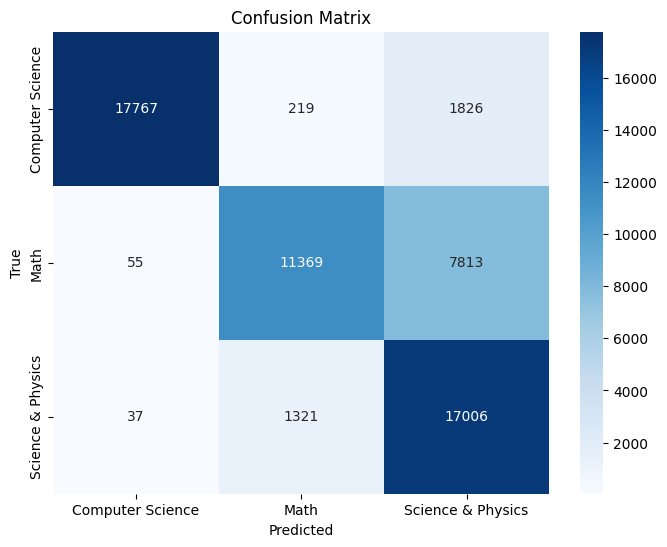

In [74]:
print("\n=== Section 7: Model Evaluation ===")
y_pred = model.predict(X_test_bow)
test_accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {test_accuracy:.2%}")

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()


In [76]:
print("\n=== Section 9: Feature Importance Analysis ===")
feature_names = bow_vectorizer.feature_names
weights = model.weights  # Shape: [n_features, n_classes]
for class_idx, class_name in enumerate(encoder.classes_):
    print(f"\nTop 20 features for {class_name}:")
    top_indices = np.argsort(weights[:, class_idx])[::-1][:20]
    for idx in top_indices:
        print(f"  {feature_names[idx]}: {weights[idx, class_idx]:.4f}")


=== Section 9: Feature Importance Analysis ===

Top 20 features for Computer Science:
  computer: 0.3329
  science: 0.2666
  learn: 0.2602
  programming: 0.2564
  language: 0.2052
  data: 0.2021
  learning: 0.1790
  python: 0.1664
  topic: 0.1403
  next: 0.1381
  concept: 0.1316
  algorithm: 0.1289
  want: 0.1205
  structure: 0.1186
  basic: 0.1002
  study: 0.0984
  used: 0.0874
  development: 0.0824
  java: 0.0790
  course: 0.0779

Top 20 features for Math:
  answer: 0.1874
  co: 0.1646
  final: 0.1645
  matrix: 0.1640
  sin: 0.1552
  compute: 0.1543
  dx: 0.1342
  log: 0.1222
  fraction: 0.1127
  product: 0.1101
  sqrt: 0.0997
  exp: 0.0994
  function: 0.0940
  side: 0.0906
  rule: 0.0882
  identity: 0.0828
  identify: 0.0812
  multiplication: 0.0696
  dot: 0.0655
  apply: 0.0648

Top 20 features for Science & Physics:
  boldsymbol: 0.1981
  mathrm: 0.1421
  cdot: 0.1139
  mathbf: 0.1077
  right: 0.0652
  following: 0.0619
  fraction: 0.0529
  time: 0.0467
  correct: 0.0448
  acid: 

In [77]:
# Section 10: Detailed Performance Metrics
print("\n=== Section 10: Detailed Performance Metrics ===")
print("Classification Report:")
report = classification_report(y_test_enc, y_pred, target_names=encoder.classes_, output_dict=True)
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']
print(f"Macro F1 Score: {macro_f1:.2%}")
print(f"Weighted F1 Score: {weighted_f1:.2%}")


=== Section 10: Detailed Performance Metrics ===
Classification Report:
                   precision    recall  f1-score   support

 Computer Science       0.99      0.90      0.94     19812
             Math       0.88      0.59      0.71     19237
Science & Physics       0.64      0.93      0.76     18364

         accuracy                           0.80     57413
        macro avg       0.84      0.80      0.80     57413
     weighted avg       0.84      0.80      0.80     57413

Macro F1 Score: 80.21%
Weighted F1 Score: 80.42%


In [68]:
print("\n=== Section 11: Manual Testing ===")
def manual_test_input(input_text, vectorizer, model, encoder):
    cleaned_text = preprocess_input(input_text)
    X_input = vectorizer.transform([cleaned_text])
    probs = model.predict_proba(X_input)[0]
    pred_idx = np.argmax(probs)
    pred_label = encoder.inverse_transform([pred_idx])[0]
    confidence = probs[pred_idx]
    return pred_label, confidence

test_inputs = [
    "integrate x^2 dx",
    "neural network backpropagation",
    "quantum entanglement"
]
for input_text in test_inputs:
    label, conf = manual_test_input(input_text, bow_vectorizer, model, encoder)
    print(f"Input: {input_text}")
    print(f"Predicted Label: {label}, Confidence: {conf:.2%}\n")


=== Section 11: Manual Testing ===
Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1301.37it/s]


Input: integrate x^2 dx
Predicted Label: Math, Confidence: 37.08%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1356.94it/s]


Input: neural network backpropagation
Predicted Label: Computer Science, Confidence: 34.34%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1424.70it/s]

Input: quantum entanglement
Predicted Label: Science & Physics, Confidence: 34.47%



In [71]:
print("\n=== Section 11: Manual Testing ===")
def manual_test_input(input_text, vectorizer, model, encoder):
    cleaned_text = preprocess_input(input_text)
    X_input = vectorizer.transform([cleaned_text])
    probs = model.predict_proba(X_input)[0]
    pred_idx = np.argmax(probs)
    pred_label = encoder.inverse_transform([pred_idx])[0]
    confidence = probs[pred_idx]
    return pred_label, confidence

# Get user inputs
test_inputs = []
print("Enter questions one by one. Type 'quit' to stop.")

while True:
    question = input("Enter question: ")
    if question.lower() == 'quit':
        break
    test_inputs.append(question)

# Perform manual testing
if test_inputs:
    print("\nPerforming manual tests:")
    for input_text in test_inputs:
        label, conf = manual_test_input(input_text, bow_vectorizer, model, encoder)
        print(f"Input: {input_text}")
        print(f"Predicted Label: {label}, Confidence: {conf:.2%}\n")
else:
    print("No inputs provided.")


=== Section 11: Manual Testing ===
Enter questions one by one. Type 'quit' to stop.
Enter question: Newton’s first law describes the principle of inertia.
Enter question: A matrix is a rectangular array of numbers or expressions.
Enter question: Probability measures the likelihood of an event occurring.
Enter question: Electrons orbit the nucleus of an atom in energy levels.
Enter question: Water boils at 100°C under standard atmospheric pressure.
Enter question: The derivative of x² is 2x.
Enter question: The OSI model consists of seven layers for network communication.
Enter question: A compiler translates high-level code into machine code that can be executed by a computer's CPU efficiently and accurately.
Enter question: Complex numbers consist of a real part and an imaginary part, and are useful in solving equations that have no real solutions.
Enter question: Light travels in waves.
Enter question: SQL queries retrieve data.
Enter question: Integration is the reverse process of 


Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1478.95it/s]


Input: Newton’s first law describes the principle of inertia.
Predicted Label: Science & Physics, Confidence: 34.45%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1038.71it/s]


Input: A matrix is a rectangular array of numbers or expressions.
Predicted Label: Math, Confidence: 35.72%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1317.72it/s]


Input: Probability measures the likelihood of an event occurring.
Predicted Label: Science & Physics, Confidence: 34.30%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1827.58it/s]


Input: Electrons orbit the nucleus of an atom in energy levels.
Predicted Label: Science & Physics, Confidence: 35.32%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1551.72it/s]


Input: Water boils at 100°C under standard atmospheric pressure.
Predicted Label: Science & Physics, Confidence: 34.65%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1510.92it/s]


Input: The derivative of x² is 2x.
Predicted Label: Math, Confidence: 35.04%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1784.81it/s]


Input: The OSI model consists of seven layers for network communication.
Predicted Label: Science & Physics, Confidence: 33.92%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1226.76it/s]


Input: A compiler translates high-level code into machine code that can be executed by a computer's CPU efficiently and accurately.
Predicted Label: Computer Science, Confidence: 35.63%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1538.63it/s]


Input: Complex numbers consist of a real part and an imaginary part, and are useful in solving equations that have no real solutions.
Predicted Label: Math, Confidence: 34.19%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1702.23it/s]


Input: Light travels in waves.
Predicted Label: Science & Physics, Confidence: 34.58%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 2133.42it/s]


Input: SQL queries retrieve data.
Predicted Label: Computer Science, Confidence: 34.94%

Preprocessing texts for transform...



Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 1493.70it/s]

Input: Integration is the reverse process of differentiation and is used to calculate areas under curves or to solve differential equations.
Predicted Label: Science & Physics, Confidence: 33.91%



In [78]:
# Section 12: Training, Validation, and Test Curve Plots
print("\n=== Section 12: Training, Validation, and Test Curve Plots ===")
iterations = list(range(0, len(model.train_loss) * 100, 100))

plt.figure(figsize=(12, 5))



=== Section 12: Training, Validation, and Test Curve Plots ===


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

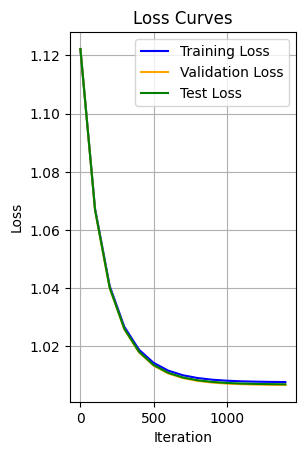

In [79]:
# Subplot 1: Loss Curves
plt.subplot(1, 2, 1)
plt.plot(iterations, model.train_loss, label='Training Loss', color='blue')
plt.plot(iterations, model.val_loss, label='Validation Loss', color='orange')
plt.plot(iterations, model.test_loss, label='Test Loss', color='green')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

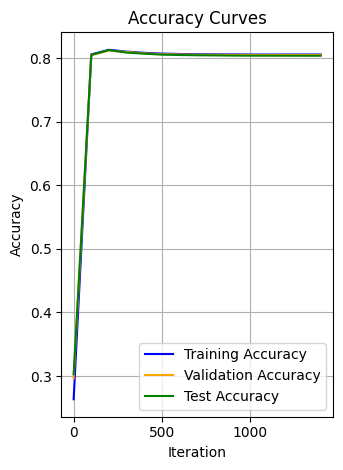

In [80]:
# Subplot 2: Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(iterations, model.train_acc, label='Training Accuracy', color='blue')
plt.plot(iterations, model.val_acc, label='Validation Accuracy', color='orange')
plt.plot(iterations, model.test_acc, label='Test Accuracy', color='green')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()